# Perception Encoder Demo
[![Paper](https://img.shields.io/badge/Paper-Perception%20Encoder-b31b1b.svg)](https://ai.meta.com/research/publications/perception-encoder-the-best-visual-embeddings-are-not-at-the-output-of-the-network)
[![Paper](https://img.shields.io/badge/arXiv-2504.13181-brightgreen.svg?style=flat-square)](https://arxiv.org/abs/2504.13181)
[![Hugging Face Collection](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Collection-blue)](https://huggingface.co/collections/facebook/perception-encoder-67f977c9a65ca5895a7f6ba1)
[![Model License](https://img.shields.io/badge/Model_License-Apache_2.0-olive)](https://opensource.org/licenses/Apache-2.0)

This notebook provides examples of image and video feature extraction with pre-trained Perception Encoder (PE). These featuire can be used for image and video zero-shot classification and retrieval.

You can run the demo locally or run it on Google colab. You can also run it with (faster) or wihtout GPU.

### Prepare Environment

In [3]:
!pip3 install decord

ERROR: Could not find a version that satisfies the requirement decord (from versions: none)
ERROR: No matching distribution found for decord


In [6]:
import os, sys
import torch
import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
print('Running in Colab.')
!git clone https://github.com/facebookresearch/perception_models.git
# !pip install decord
!pip install ftfy
sys.path.append('./perception_models')
os.chdir('./perception_models')

if torch.cuda.is_available():
    print('GPU is available. Use GPU for this demo')
else:
    print('Use CPU for this demo')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Running in Colab.
Cloning into 'perception_models'...
remote: Enumerating objects: 608, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 608 (delta 129), reused 82 (delta 72), pack-reused 445 (from 1)
Receiving objects: 100% (608/608), 12.21 MiB | 28.86 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Use CPU for this demo


### Create Model and Preprocess Transform

The following code creates a PE-core model and loads pretrained checkpoints. Then it gets the preprocess image transfrom and text tokenizer. The models available are:
- PE-core-G14-448
- PE-core-L14-336
- PE-core-B16-224

In [15]:
import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms
from huggingface_hub import hf_hub_download

# Only run this once to confirm the path
local_ckpt_path = hf_hub_download(
    repo_id="facebook/PE-Core-B16-224",
    filename="PE-Core-B16-224.pt"
)

model_name = 'PE-Core-B16-224'

model = pe.CLIP.from_config(model_name, pretrained=True, checkpoint_path=local_ckpt_path)
model = model.to(device)

preprocess = transforms.get_image_transform(model.image_size)
tokenizer = transforms.get_text_tokenizer(model.context_length)

Missing keys for loading model: []
Unexpected keys for loading model: []


### Example 1: Image and Text Feature Extraction for Zero-shot Image Classification/Retrieval

In this example, we extract the embedding of a cat image, and the embeddings of 3 senetence. We measure the cosine similarites between the image and sentences.

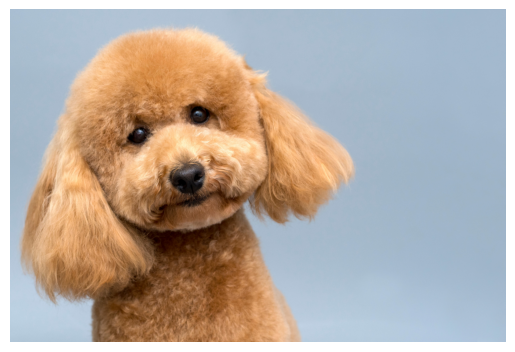

Captions: ['a husky', 'a poodle', 'a german shepherd']
Label probs: 0.00 1.00 0.00
This image is about a poodle


In [19]:
image = preprocess(Image.open("./apps/pe/docs/assets/dog.png")).unsqueeze(0).to(device)
captions = ["a husky", "a poodle", "a german shepherd"]
text = tokenizer(captions).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

plt.imshow(Image.open("./apps/pe/docs/assets/dog.png"))
plt.axis('off')
plt.show()
print("Captions:", captions)
print("Label probs:", ' '.join(['{:.2f}'.format(prob) for prob in text_probs]))  # prints: [[0.00, 0.00, 1.00]]
print(f"This image is about {captions[text_probs.argmax()]}")

### Example 2: Video and Text Feature Extraction for Zero-shot Video Classification/Retrieval

In this example, we extract the embedding of a dog video, and the embeddings of 3 senetence. We measure the cosine similarites between the video and sentences. We first create a simple video preprocess function to process video input

In [ ]:
def preprocess_video(video_path, num_frames=8, transform=None, return_first_frame_for_demo=True):
    """
    Uniformly samples a specified number of frames from a video and preprocesses them.
    Parameters:
    - video_path: str, path to the video file.
    - num_frames: int, number of frames to sample. Defaults to 8.
    - transform: torchvision.transforms, a transform function to preprocess frames.
    Returns:
    - Video Tensor: a tensor of shape (num_frames, 3, H, W) where H and W are the height and width of the frames.
    """
    # Load the video
    vr = decord.VideoReader(video_path)
    total_frames = len(vr)
    # Uniformly sample frame indices
    frame_indices = [int(i * (total_frames / num_frames)) for i in range(num_frames)]
    frames = vr.get_batch(frame_indices).asnumpy()
    # Preprocess frames
    preprocessed_frames = [transform(Image.fromarray(frame)) for frame in frames]

    first_frame = None
    if return_first_frame_for_demo:
        first_frame = frames[0]
    return torch.stack(preprocessed_frames, dim=0), first_frame

Then we use the encode_video function to encode video to get video embeddings. And compare the cosine similaries with the text emebddings.

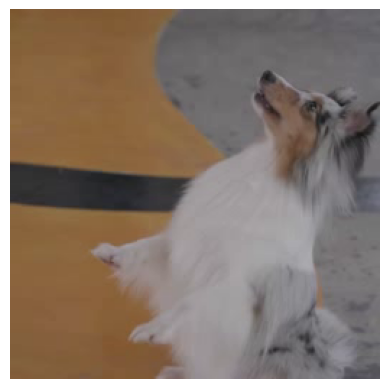

Captions: ['a diagram', 'a dog', 'a cat']
Label probs: 0.00 1.00 0.00
This video is about a dog


In [ ]:
video, first_frame = preprocess_video("./apps/pe/docs/assets/dog.mp4", 8, transform=preprocess)
video = video.unsqueeze(0).to(device)
text = tokenizer(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_video(video)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

plt.imshow(Image.fromarray(first_frame))
plt.axis('off')
plt.show()
print("Captions:", captions)
print("Label probs:", ' '.join(['{:.2f}'.format(prob) for prob in text_probs]))  # prints: [[0.00, 1.00, 0.00]]
print(f"This video is about {captions[text_probs.argmax()]}")